# Forecasting climate change with NY temperature data

*by Marco Stallmann (2022)*

In this notebook we analyze New York City average annual temperature data from 1870 to 2016. The data was downloaded from the National Oceanic and Atmospheric Administration (NOAA) [website](https://www.ncdc.noaa.gov/cdo-web/search). We are going to test if the data reflect a Random Walk and take first differences to then transform it into a stationary series. We compute the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the data. Using that as a guide we fit Autoregression (AR), Moving Average (MA) and ARMA models to the data and use an Information Criterion to choose the best model. With this we can forecast temperatures of the next 30 years.

*This case study was created as part of the course [Time Series Analysis in Python](https://www.datacamp.com/courses/time-series-analysis-in-python/continue) by [Datacamp.com](https://www.datacamp.com).*

In [29]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller

In [30]:
# Read data
temp_NY = pd.read_csv('data/NOAA_TAVG.csv')
temp_NY = temp_NY.set_index('DATE')
temp_NY.head()

,TAVG
DATE,
1870,53.8
1871,51.3
1872,51.3
1873,50.9
1874,51.3


We plot the data and test whether it follows a Random Walk (with drift).

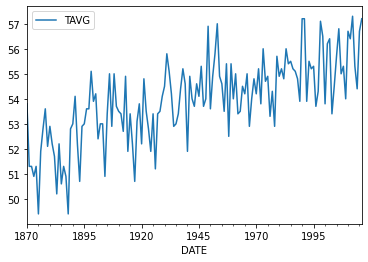

In [31]:
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

In [32]:
# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  0.5832938987871121


Since the temperature series is a random walk with drift, we take first differences to make it stationary. Then we compute the sample ACF and PACF. This will provide some guidance on the order of the model.

C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


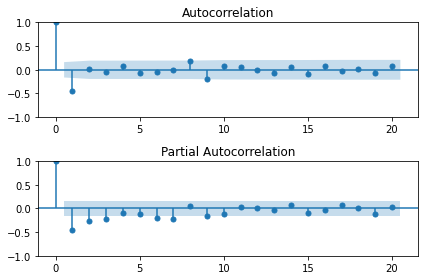

In [33]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])

fig.tight_layout()

plt.show()

There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF. The Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

We fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [34]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 0, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Py

The AIC for an AR(1) is:  510.5346898733109
The AIC for an AR(2) is:  501.92741234091363
The AIC for an ARMA(1,1) is:  469.07291879070664


The ARMA(1,1) has the lowest AIC values among the three models. So we will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, we determined that the temperature data follows a random walk and we looked at first differencing the data. At this point, we use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, we will also need to add a trend component when we define the ARIMA model. 

C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\marco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


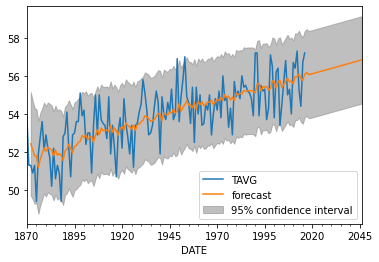

In [40]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.